- ~~Random Forest~~
- ~~LightGBM~~
- CatBoost

- ~~MLP~~
- ~~1D-CNN~~

### Обоснование выбора

Градиентный бустинг — золотой стандарт для QSAR-задач на небольших выборках и табличных данных.

- **CatBoost** умеет автоматически обрабатывать разреженные дескрипторы (ECFP + Mordred), устойчив к шуму и малым датасетам.
- **Нейросети** требуют больше данных для стабильности; MLP при малом числе признаков (≈ 1 000) и 4 000 образцах ещё работает, но CNN скорее всего не очень.

_Также на команду уже подгрузили 3 задачу, приступил поздно и времени осталось мало — поэтому было принято решение сфокусироваться на последней задаче_

In [1]:
# input_dim = X_train.shape[1]

# def build_mlp():
#     inp = layers.Input(shape=(input_dim,))
#     x   = layers.Dense(256, activation='relu')(inp)
#     x   = layers.Dropout(0.2)(x)
#     x   = layers.Dense(128, activation='relu')(x)
#     x   = layers.Dropout(0.2)(x)
#     out = layers.Dense(1, activation='linear')(x)
#     model = Model(inp, out)
#     model.compile(optimizer='adam', loss='mse')
#     return model

# # Обёртка для sklearn-подхода
# mlp = KerasRegressor(build_fn=build_mlp,
#                      epochs=50,
#                      batch_size=32,
#                      verbose=0)

# print("\n→ CV for MLP")
# mlp_res = cv_metrics(mlp, X_train, y_train)
# print(pd.DataFrame(mlp_res).agg(['mean','std']).T)
# cv_results['MLP'] = pd.DataFrame(mlp_res)

In [2]:
# # reshape для Conv1D: (samples, features, 1)
# Xc = X_train[..., np.newaxis]

# def build_cnn():
#     inp = layers.Input(shape=(input_dim,1))
#     x   = layers.Conv1D(64, 5, activation='relu', padding='same')(inp)
#     x   = layers.MaxPool1D(2)(x)
#     x   = layers.Conv1D(32, 3, activation='relu', padding='same')(x)
#     x   = layers.GlobalMaxPool1D()(x)
#     x   = layers.Dense(64, activation='relu')(x)
#     out = layers.Dense(1, activation='linear')(x)
#     model = Model(inp, out)
#     model.compile(optimizer='adam', loss='mse')
#     return model

# cnn = KerasRegressor(build_fn=build_cnn,
#                      epochs=50,
#                      batch_size=32,
#                      verbose=0)

# # адаптируем cv_metrics для CNN reshape
# def cv_cnn(model, X, y, n_splits=5):
#     kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
#     rmses, maes, r2s = [], [], []
#     for tr, val in kf.split(X):
#         X_tr, X_val = X[tr][...,np.newaxis], X[val][...,np.newaxis]
#         y_tr, y_val = y[tr], y[val]
#         model.fit(X_tr, y_tr)
#         pred = model.predict(X_val)
#         rmse = np.sqrt(mean_absolute_error(y_val, pred)**2)
#         rmses.append(rmse)
#         maes.append(mean_absolute_error(y_val, pred))
#         r2s.append(r2_score(y_val, pred))
#     return {'RMSE': rmses, 'MAE': maes, 'R2': r2s}

# print("\n→ CV for 1D-CNN")
# cnn_res = cv_cnn(cnn, X_train, y_train)
# print(pd.DataFrame(cnn_res).agg(['mean','std']).T)
# cv_results['1D-CNN'] = pd.DataFrame(cnn_res)

# imports & reproducibility

In [3]:
import os
import numpy as np
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

from catboost import CatBoostRegressor, Pool

import seaborn as sns
import matplotlib.pyplot as plt


SEED = 42
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# load & check data

In [4]:
df = pd.read_csv('../../data/target_cox2_IC50__descriptors_with_ECFP6.csv')
print("Original shape:", df.shape)

# Колонки, которые не участвуют в модели
non_feat = ['Smiles', 'Molecule ChEMBL ID']
df_feat = df.drop(columns=non_feat)

#Приводим всё к float64, нечисловые значения → NaN
df_feat = df_feat.apply(pd.to_numeric, errors='coerce')

# Сразу убираем признаки, где хоть в одном образце NaN
df_feat = df_feat.dropna(axis=1, how='any')
print("After dropna columns:", df_feat.shape)

# Разделяем на X и y
X = df_feat.drop(columns=['pIC50']).values
y = df_feat['pIC50'].values
print("X shape:", X.shape, "y shape:", y.shape)

C:\Users\MRVen\AppData\Local\Temp\ipykernel_22068\3004425524.py:1: DtypeWarning: Columns (1487,1488,1510,1511,1512,1513,1514,1545,1547,1548,1557,1558,1559,1560,1561,1562,1578,1581,1582,1585) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../data/target_cox2_IC50__descriptors_with_ECFP6.csv')


Original shape: (3967, 1743)
After dropna columns: (3967, 1719)
X shape: (3967, 1718) y shape: (3967,)


In [5]:
# Проверка на дублирование колонок по содержимому


# Метод 1: простой способ через transpose+duplicated
dup_cols = df_feat.columns[df_feat.T.duplicated()]
if len(dup_cols): print("Найдены дублированные колонки:", dup_cols.tolist())
else: print("Дублированных колонок не обнаружено")


# Метод 2: явная проверка парой
from itertools import combinations

dup_pairs = []
for c1, c2 in combinations(df_feat.columns, 2):
    if df_feat[c1].equals(df_feat[c2]):
        dup_pairs.append((c1, c2))

if dup_pairs:
    print("Пары колонок с одинаковым содержимым:")
    for p in dup_pairs: print(" ", p)
else: print("Никаких пар дублирующих колонок не найдено")

Дублированных колонок не обнаружено
Никаких пар дублирующих колонок не найдено


In [6]:
# df_feat = df_feat.drop(columns=dup_cols)
# print("After drop duplicates:", df_feat.shape)

# split & scale

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# Сохраняем scaler для последующего использования
joblib.dump(scaler, '../scaler.pkl')
print("Train/Test shapes:", X_train.shape, X_test.shape)

Train/Test shapes: (3173, 1718) (794, 1718)


# 5-Fold CV с CatBoostRegressor

In [8]:
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

cv_rmse, cv_mae, cv_r2 = [], [], []

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train), 1):
    X_tr, X_val = X_train[tr_idx], X_train[val_idx]
    y_tr, y_val = y_train[tr_idx], y_train[val_idx]

    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        eval_metric='RMSE',
        random_seed=SEED,
        logging_level='Silent',
        early_stopping_rounds=50
    )
    # обёртка Pool даёт чуть более точный учет категорий и weight’ов
    train_pool = Pool(X_tr, y_tr)
    val_pool   = Pool(X_val, y_val)

    model.fit(train_pool, eval_set=val_pool, use_best_model=True)

    y_pred = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    mae  = mean_absolute_error(y_val, y_pred)
    r2   = r2_score(y_val, y_pred)

    cv_rmse.append(rmse)
    cv_mae.append(mae)
    cv_r2.append(r2)

    print(f"Fold {fold}: RMSE={rmse:.3f}, MAE={mae:.3f}, R2={r2:.3f}")

# Итоги CV
print("\nCV summary:")
print(f" RMSE: {np.mean(cv_rmse):.3f} ± {np.std(cv_rmse):.3f}")
print(f"  MAE: {np.mean(cv_mae):.3f} ± {np.std(cv_mae):.3f}")
print(f"   R²: {np.mean(cv_r2):.3f} ± {np.std(cv_r2):.3f}")

df_cv = pd.DataFrame({'RMSE': cv_rmse, 'MAE': cv_mae, 'R2': cv_r2})

Fold 1: RMSE=0.754, MAE=0.579, R2=0.546
Fold 2: RMSE=0.798, MAE=0.587, R2=0.513
Fold 3: RMSE=0.761, MAE=0.581, R2=0.554
Fold 4: RMSE=0.736, MAE=0.538, R2=0.550
Fold 5: RMSE=0.762, MAE=0.570, R2=0.543

CV summary:
 RMSE: 0.762 ± 0.020
  MAE: 0.571 ± 0.018
   R²: 0.541 ± 0.015


Сводная статистика по метрикам CV:
          mean       std       min       max
RMSE  0.762130  0.022860  0.735649  0.798393
MAE   0.570988  0.019566  0.537674  0.586914
R2    0.541070  0.016354  0.512714  0.553536


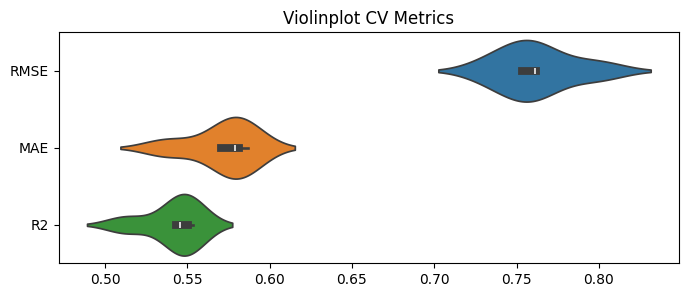

In [9]:
# Визуализация

summary = df_cv.agg(['mean','std','min','max']).T
print("Сводная статистика по метрикам CV:")
print(summary)

plt.figure(figsize=(8,3))
sns.violinplot(data=df_cv, orient='h')
plt.title("Violinplot CV Metrics")
plt.show()

# final train & test evaluation

0:	learn: 1.1177345	total: 56.4ms	remaining: 56.3s
1:	learn: 1.1095855	total: 108ms	remaining: 53.7s
2:	learn: 1.1001806	total: 153ms	remaining: 50.8s
3:	learn: 1.0924139	total: 201ms	remaining: 50s
4:	learn: 1.0855164	total: 246ms	remaining: 48.9s
5:	learn: 1.0800624	total: 300ms	remaining: 49.7s
6:	learn: 1.0719391	total: 372ms	remaining: 52.7s
7:	learn: 1.0642589	total: 432ms	remaining: 53.6s
8:	learn: 1.0562170	total: 473ms	remaining: 52.1s
9:	learn: 1.0503651	total: 517ms	remaining: 51.2s
10:	learn: 1.0458503	total: 571ms	remaining: 51.3s
11:	learn: 1.0402394	total: 644ms	remaining: 53.1s
12:	learn: 1.0344403	total: 702ms	remaining: 53.3s
13:	learn: 1.0285118	total: 754ms	remaining: 53.1s
14:	learn: 1.0239436	total: 800ms	remaining: 52.5s
15:	learn: 1.0194695	total: 858ms	remaining: 52.8s
16:	learn: 1.0150584	total: 909ms	remaining: 52.6s
17:	learn: 1.0112124	total: 951ms	remaining: 51.9s
18:	learn: 1.0061621	total: 995ms	remaining: 51.4s
19:	learn: 1.0015809	total: 1.04s	remainin

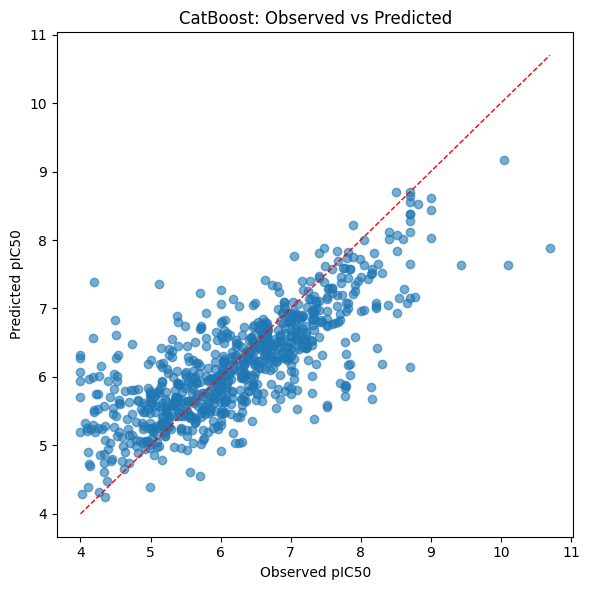

In [10]:
final_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    random_seed=SEED,
    # logging_level='Silent'
)
final_model.fit(X_train, y_train)

# Сохраняем модель
final_model.save_model('../models/catboost_cox2_model.cbm')
joblib.dump(final_model, '../models/catboost_cox2_model.pkl')

# Предсказание на тесте
y_test_pred = final_model.predict(X_test)
rmse_test = root_mean_squared_error(y_test, y_test_pred)
mae_test  = mean_absolute_error(y_test, y_test_pred)
r2_test   = r2_score(y_test, y_test_pred)

print(f"Test set → RMSE={rmse_test:.3f}, MAE={mae_test:.3f}, R²={r2_test:.3f}")

# График: предсказанное vs наблюдаемое
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=1)
plt.xlabel("Observed pIC50")
plt.ylabel("Predicted pIC50")
plt.title("CatBoost: Observed vs Predicted")
plt.tight_layout()
plt.show()

# ИТОГ

1. Стабильность на CV  
   - RMSE = 0.762 ± 0.020 pIC₅₀-единиц  
   - MAE  = 0.571 ± 0.018 pIC₅₀-ед  
   - R²   = 0.541 ± 0.015  
   
   Небольшие σ говорят о том, что модель показывает примерно одинаковое качество на любых 20 % данных. Значит, она не слишком «переобучается» на каком-то одном разбиении.

2. Итоговая оценка на отложенной тестовой выборке  
   - RMSE = 0.727  
   - MAE  = 0.533  
   - R²   = 0.585  
   
   Здесь ошибки чуть ниже, а R² чуть выше, чем в среднем на CV. Это означает, что модель даже чуть лучше обобщается на новых молекулах, чем ожидалось из кросс-валидации.

3. Что это значит в контексте pIC₅₀  
   - RMSE ≈ 0.73 pIC₅₀ → среднеквадратичная погрешность ≈ 0.73 ед. по логарифмической шкале. На шкале IC₅₀ это примерно 5–6-кратную ошибку в концентрации.  
   - MAE ≈ 0.53 → в среднем ваша предсказанная pIC₅₀ отклоняется от реальной на пол-единицы.  
   - R² ≈ 0.58 → модель объясняет около 58 % дисперсии активности по вашим дескрипторам.

4. Визуализация (scatter-plot)  
   – Точки группируются вдоль диагонали y = x, без явного систематического смещения вверх или вниз.  
   – Разброс увеличивается при крайних значениях, что типично для QSAR-задач.

5. Выводы и следующие шаги  
   - Текущий CatBoost + ECFP6+2D-дескрипторы даёт **среднюю точность** для раннего этапа генерации («hit prioritization»).  
   - Чтобы улучшить:  
     • поиграться с гиперпараметрами (глубина, learning_rate, number of leaves)  
     • добавить селекцию признаков или вложить их в алгоритмы понижения размерности (PCA, селекция по важности)  
     • собрать ансамбль (LightGBM + CatBoost) для уменьшения ошибки  
     • ~~протестировать более «грубые» 3-мерные дескрипторы или VLM-фичи для охвата других аспектов структуры.~~  